# Librerías y configuración

In [ ]:
import os
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
from gensim.corpora import Dictionary
from gensim.models import LdaSeqModel
from gensim.models.coherencemodel import CoherenceModel

os.chdir(
    "C:/Users/luism/Documents/Programacion_local/Clase/4o Año/Descubrimiento Datos Complejos/DCDC-Proyecto-Stocks"
)


os.listdir()

SEED = 289995
SAMPLE_SIZE = 1000

# Cargar datos

In [2]:
df_completo: pd.DataFrame = pd.read_pickle(
    r"C:\Users\luism\Documents\Programacion_local\Clase\4o Año\Descubrimiento Datos Complejos\DCDC-Proyecto-Stocks\notebooks\Luis\mineria_datos\Datos\03_df_noticias_fecha_procesado.pkl"
)

In [3]:
display(df_completo.head())
print(df_completo.shape)

,date,month,news,news_processed
0,2012-01-03 00:00:00+00:00,2012-01,'Mad Money Lightning Round': Stay Long Sandridge,"[mad, money, lightning, round, stay, long, san..."
1,2012-01-03 00:00:00+00:00,2012-01,Cramer's 'Mad Money' Recap: Betting Against th...,"[cramers, mad, money, recap, betting, bear, fi..."
2,2012-01-03 00:00:00+00:00,2012-01,'Mad Money Lightning Round': Stay Long Sandridge,"[mad, money, lightning, round, stay, long, san..."
3,2012-01-03 00:00:00+00:00,2012-01,BioLineRx Announces Initiation of CE Mark Regi...,"[biolinerx, announces, initiation, mark, regis..."
4,2012-01-03 00:00:00+00:00,2012-01,Hearing Rumors of the Death of Fidel Castro,"[hearing, rumor, death, fidel, castro]"


(2303734, 4)


In [4]:
# Muestra un subconjunto del dataframe original
sampled_df = (
    df_completo.sample(n=SAMPLE_SIZE, random_state=SEED)
    .sort_values("date")
    .reset_index(drop=True)
)

# Imprime la longitud original y la longitud muestreada del dataframe
print(
    "Longitud original:",
    len(df_completo),
    "Longitud muestreada:",
    len(sampled_df),
    f" - {len(sampled_df) / len(df_completo):.4f}% del total",
)

Longitud original: 2303734 Longitud muestreada: 1000  - 0.0004% del total


In [5]:
# Crea un diccionario a partir de las noticias procesadas
dictionary = Dictionary(
    tqdm.tqdm(sampled_df["news_processed"], desc="Creando diccionario")
)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crea un corpus a partir del diccionario
corpus = [
    dictionary.doc2bow(doc)
    for doc in tqdm.tqdm(sampled_df["news_processed"], desc="Creando corpus")
]

texts = sampled_df["news_processed"].tolist()

# Preparar time_slices (documentos por mes)
time_slices = sampled_df.groupby("month").size().to_list()
print("\nNúmero de periodos temporales:", len(time_slices))

Creando diccionario:   0%|          | 0/1000 [00:00<?, ?it/s]


Tamaño del vocabulario: 446


Creando corpus:   0%|          | 0/1000 [00:00<?, ?it/s]


Número de periodos temporales: 89


In [6]:
start_time = time.time()
print("Start time:", datetime.fromtimestamp(start_time).strftime("%Y-%m-%d %H:%M:%S"))

num_topics = 5
chain_variance = 0.100
dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=num_topics,
    id2word=dictionary,
    chain_variance=chain_variance,
    passes=2,
)



end_time = time.time()
print("End time:", datetime.fromtimestamp(end_time).strftime("%Y-%m-%d %H:%M:%S"))

elapsed_time = timedelta(seconds=end_time - start_time)
print("Elapsed time:", elapsed_time)

dtm.save("notebooks/Luis/mineria_datos/models/dtm_model/dtm_model")

Start time: 2024-11-22 15:19:34


c:\Users\luism\miniconda3\envs\DCDCModelos\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\luism\miniconda3\envs\DCDCModelos\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\Users\luism\miniconda3\envs\DCDCModelos\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\luism\miniconda3\envs\DCDCModelos\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\luism\miniconda3\envs\DCDCModelos\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value en

End time: 2024-11-22 16:17:10
Elapsed time: 0:57:36.053882


In [ ]:
coherences = []

for i in range(len(time_slices)):
    topics_time_i = dtm.dtm_coherence(time=i)
    coherence_model = CoherenceModel(
        topics=topics_time_i,
        texts=texts,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v",
    )
    coherences.append(coherence_model.get_coherence())

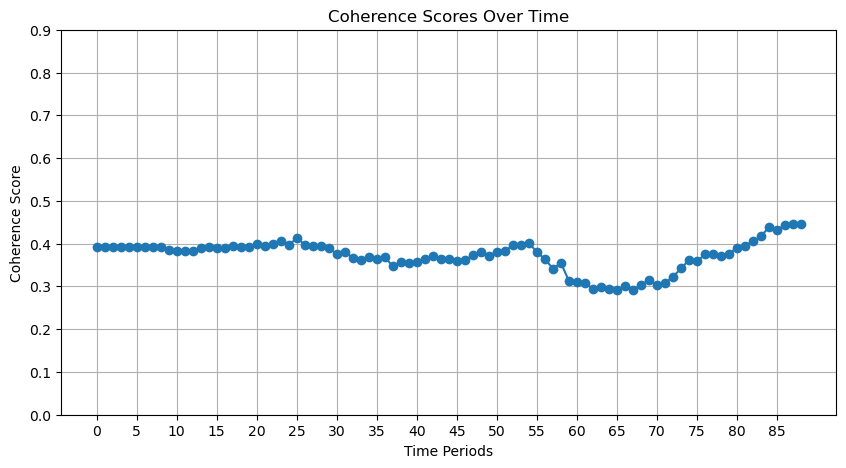

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(coherences, marker='o')
plt.title('Coherence Scores Over Time')
plt.xlabel('Time Periods')
plt.ylabel('Coherence Score')
plt.yticks(ticks=np.arange(0, 1, 0.1))
plt.xticks(ticks=np.arange(0, len(time_slices), 5))
plt.grid(True)
plt.show()

# Resultados

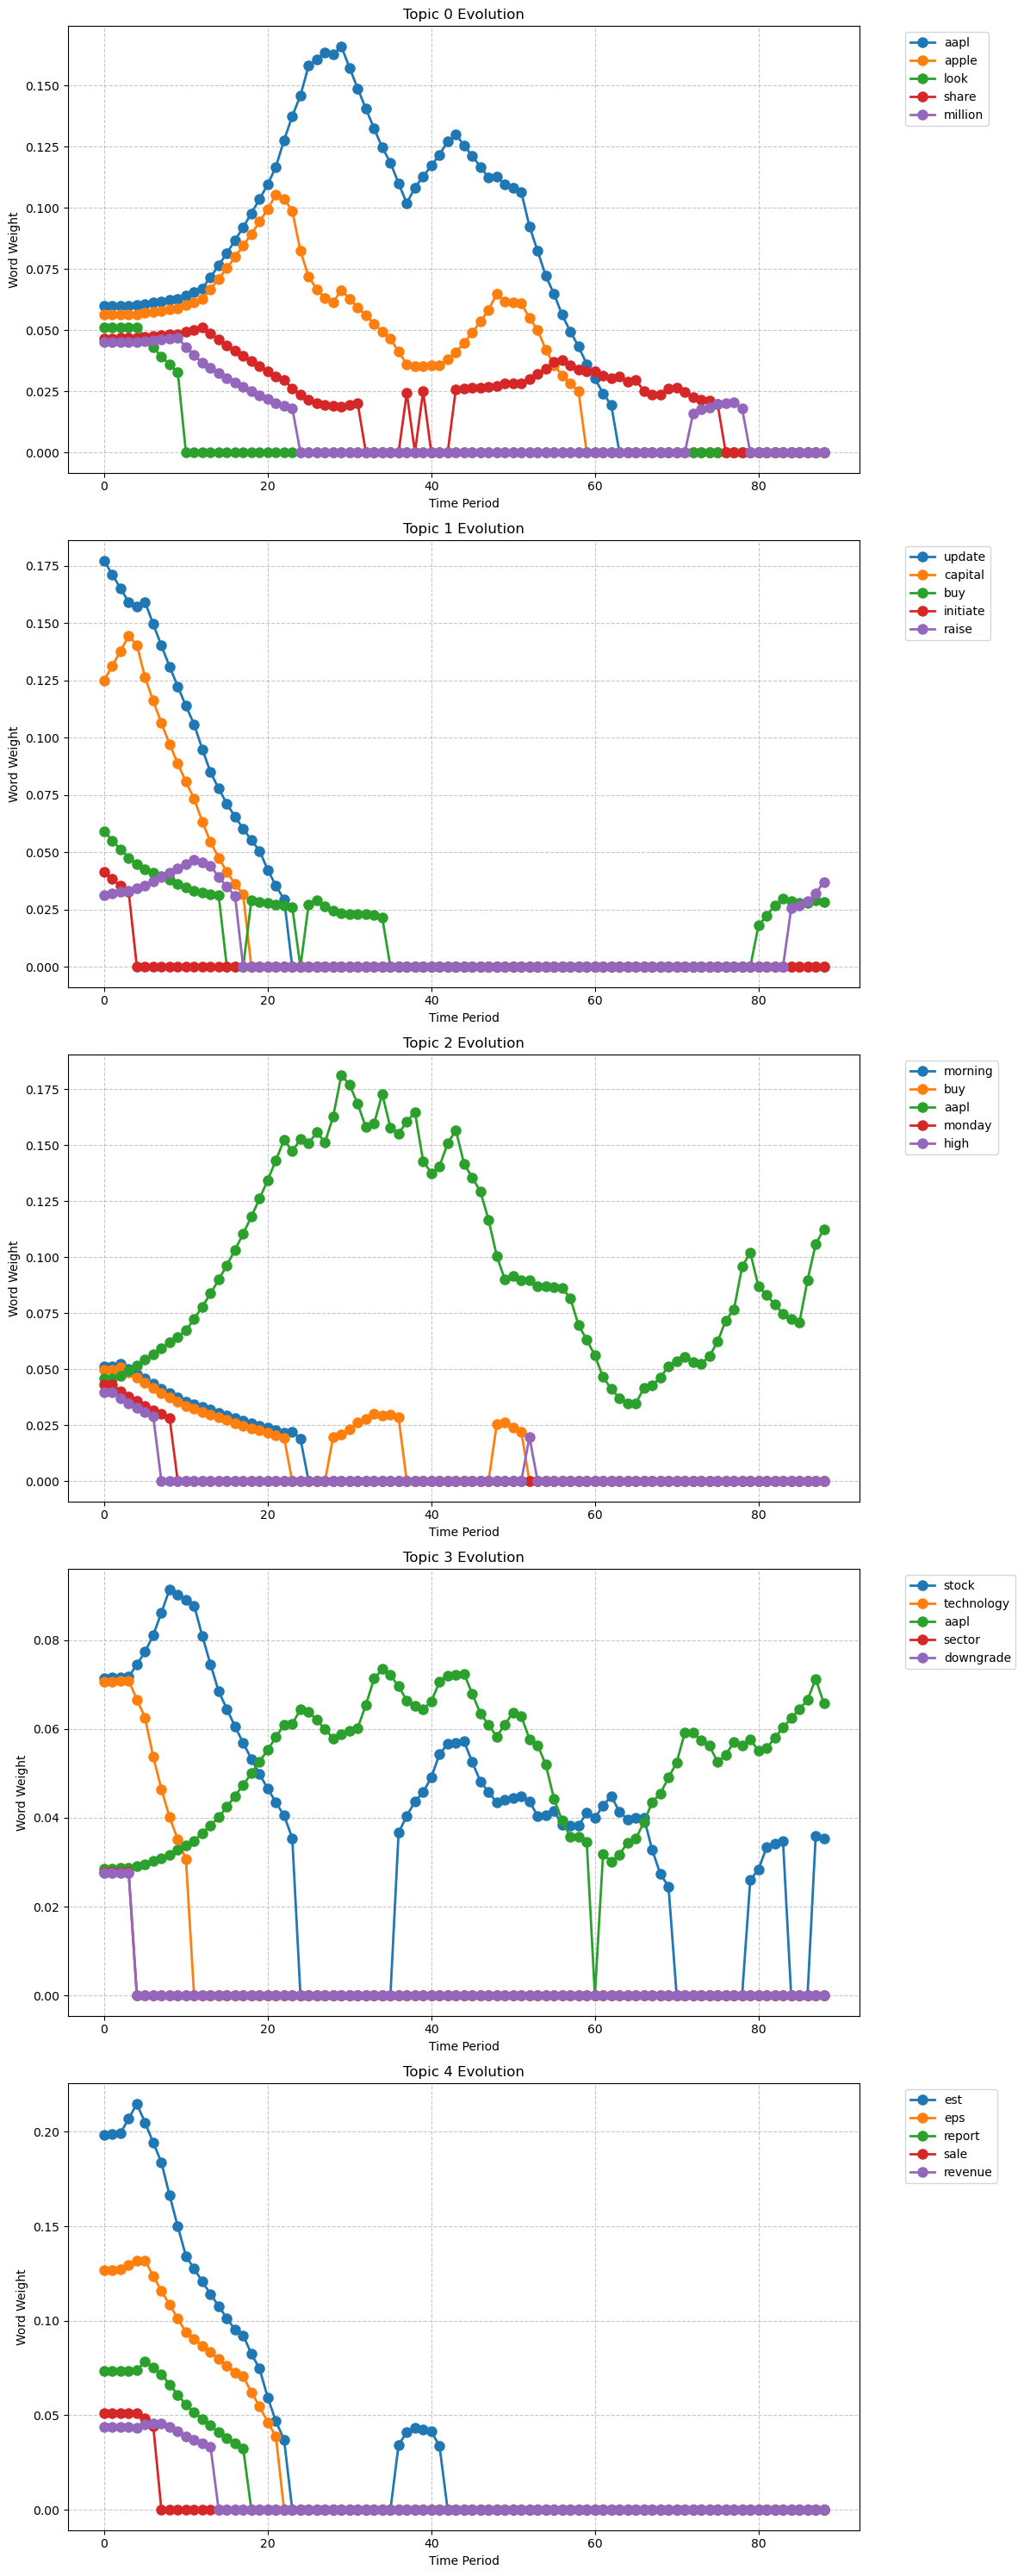

In [95]:
def plot_all_topics_timeline(model, time_slices, top_n=5):
    """Plot evolution of all topics using subplots in 5x1 grid"""
    fig = plt.figure(figsize=(12, 30))
    
    for topic_id in range(model.num_topics):
        # Get initial top 5 words from first time period
        initial_terms = model.print_topics(time=0, top_terms=top_n)[topic_id]
        top_words = [word for word, _ in initial_terms]
        
        # Initialize scores dictionary for these words only
        word_scores = {word: [0] * len(time_slices) for word in top_words}
        
        # Get data for current topic
        for t in range(len(time_slices)):
            top_terms = model.print_topics(time=t, top_terms=top_n)[topic_id]
            for word, score in top_terms:
                if word in top_words:  # Only track scores for initial top words
                    word_scores[word][t] = score
        
        # Create subplot
        ax = fig.add_subplot(5, 1, topic_id + 1)
        
        # Plot lines for top words only
        for word in top_words:
            ax.plot(range(len(time_slices)), 
                   word_scores[word],
                   marker='o',
                   linewidth=2,
                   markersize=8,
                   label=word)
                   
        ax.set_title(f'Topic {topic_id} Evolution')
        ax.set_xlabel('Time Period') 
        ax.set_ylabel('Word Weight')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return plt

plot_all_topics_timeline(dtm, time_slices, top_n=5).show()

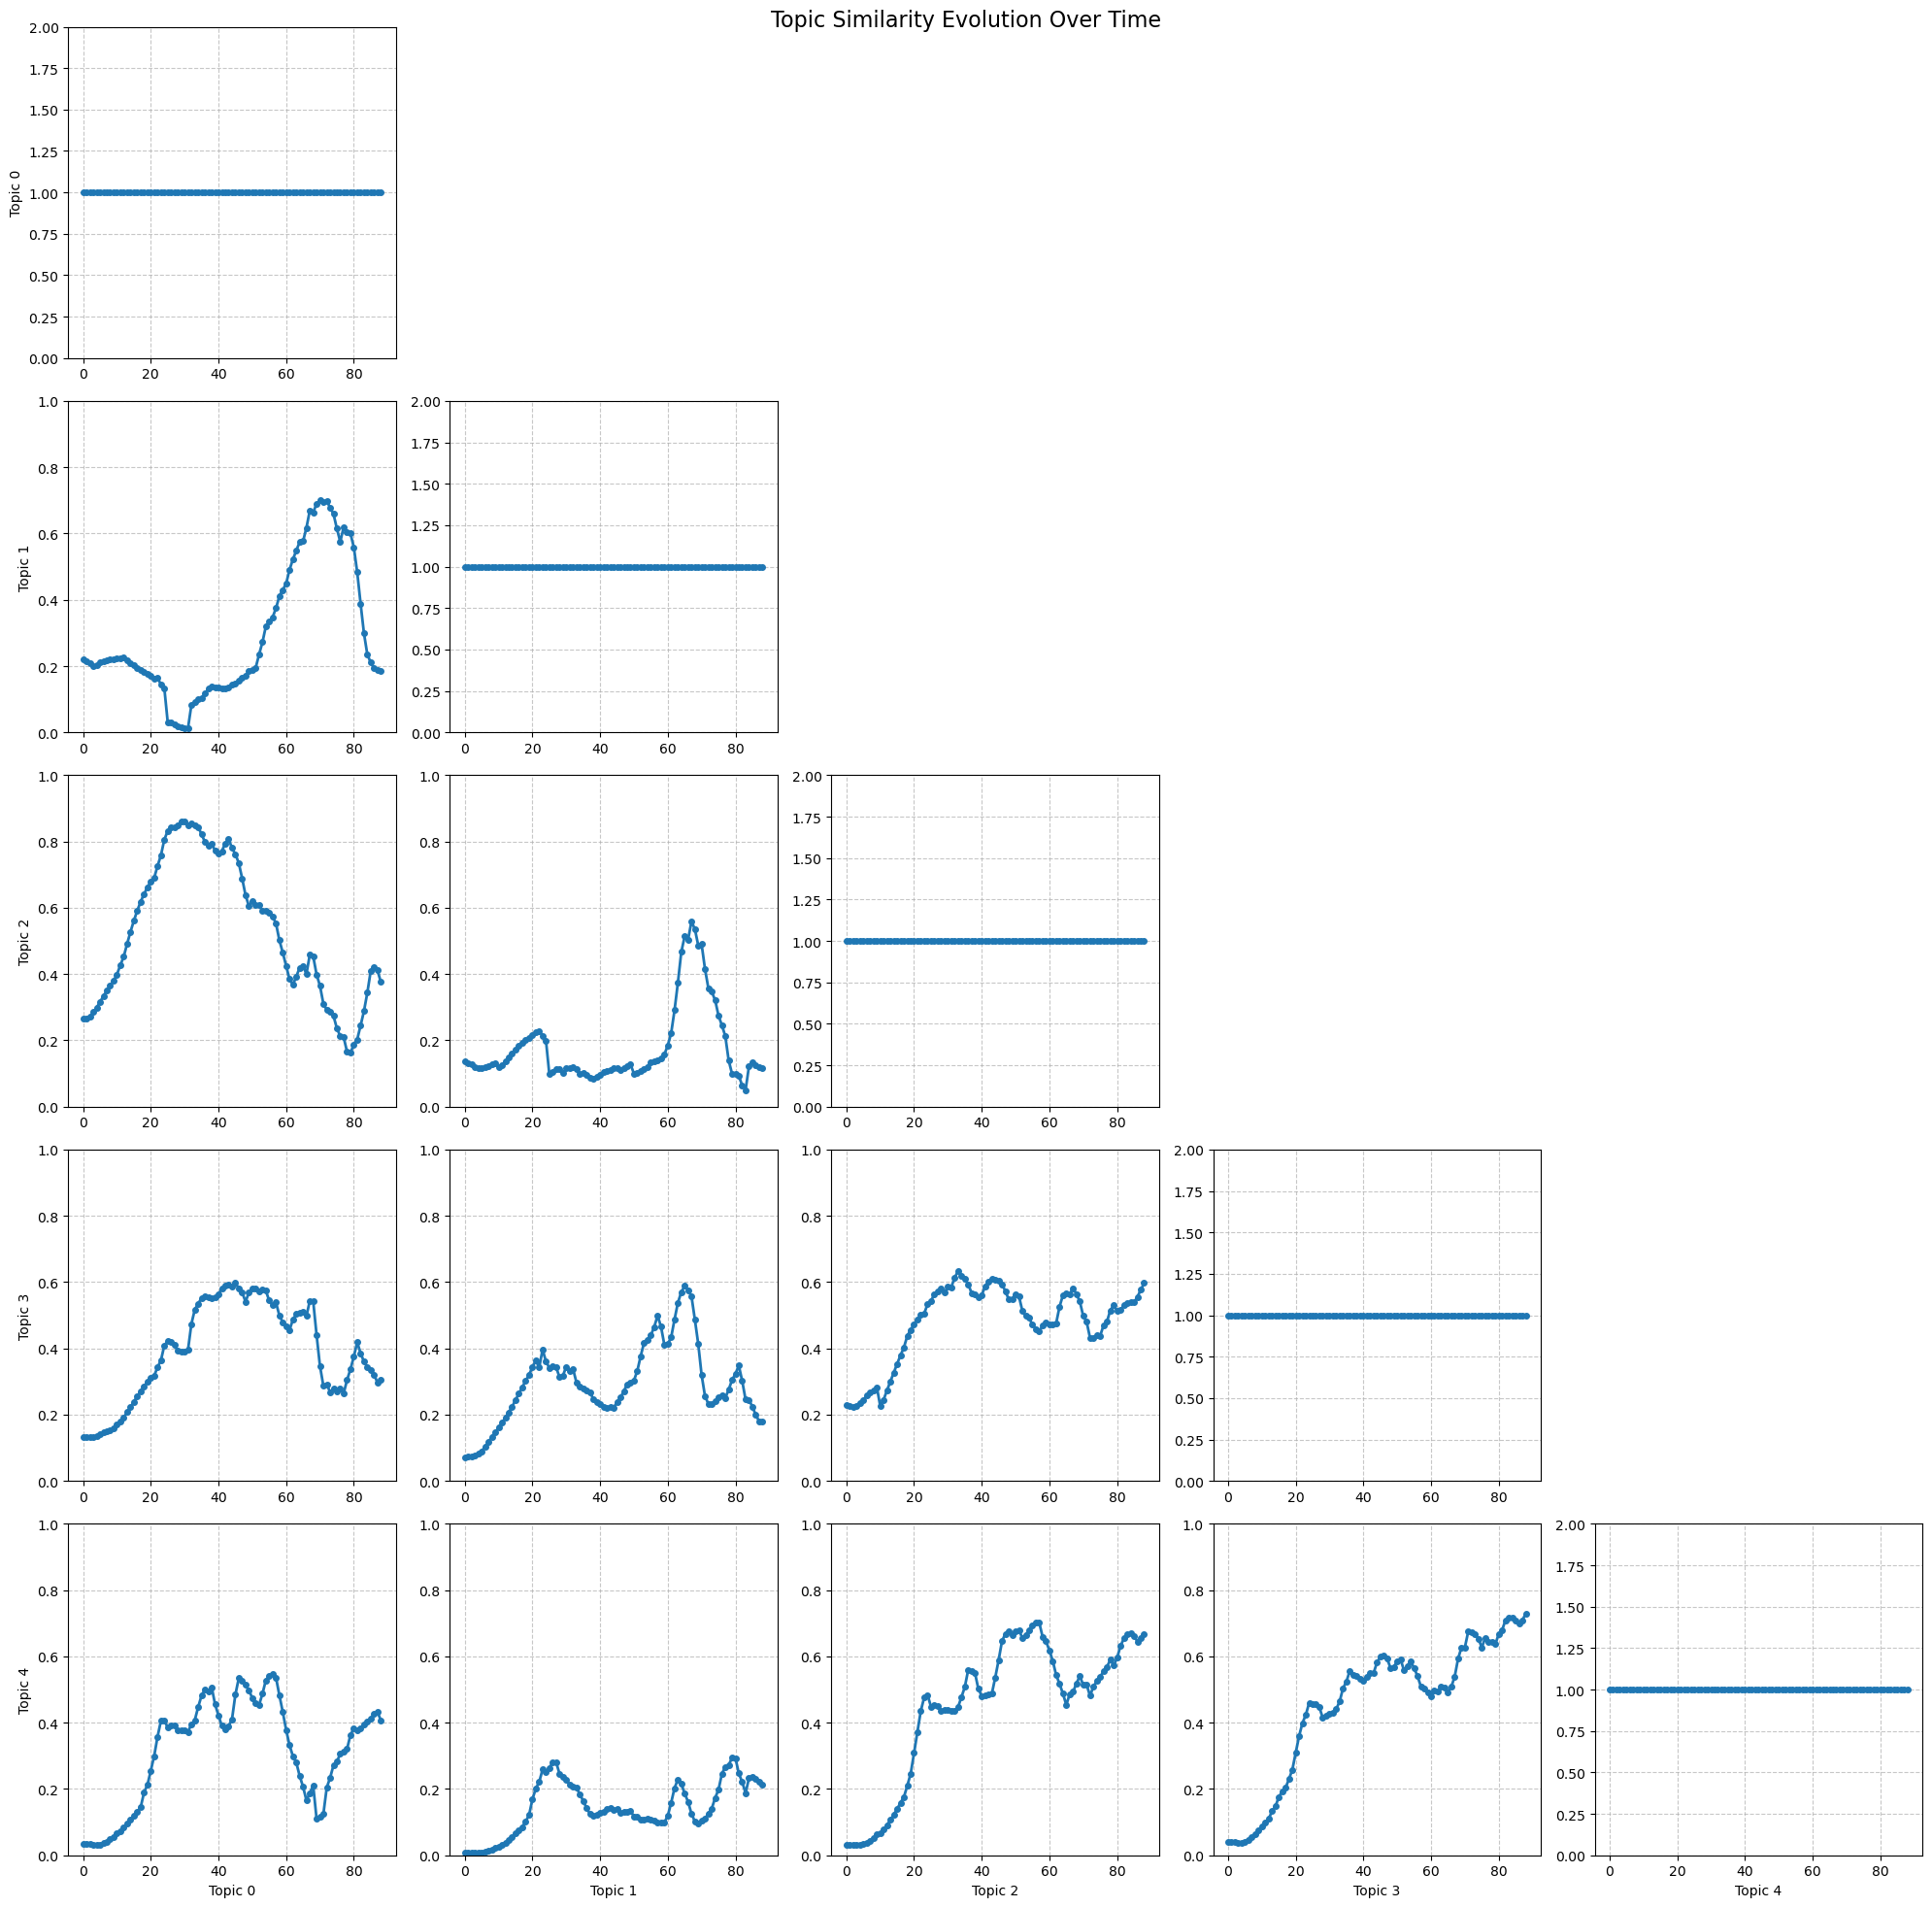

In [63]:
from scipy.spatial.distance import cosine

def plot_topic_similarity_evolution(model, time_slices):
    """Create 5x5 grid of similarity evolution plots"""
    num_topics = model.num_topics
    time_periods = len(time_slices)
    
    # Create figure with 5x5 subplots
    fig, axes = plt.subplots(num_topics, num_topics, figsize=(20, 20))
    
    # Calculate similarities over time for each topic pair
    for i in range(num_topics):
        for j in range(num_topics):
            similarities = []
            
            # If in top tringle, skip
            if i < j:
                axes[i, j].axis('off')
                continue


            # Calculate similarity for each time period
            for t in range(time_periods):
                # Get topic terms for both topics at time t
                terms_i = dict(model.print_topics(time=t)[i])
                terms_j = dict(model.print_topics(time=t)[j])
                
                # Get all words
                words = set(terms_i.keys()) | set(terms_j.keys())
                
                # Create vectors
                vec_i = [terms_i.get(word, 0) for word in words]
                vec_j = [terms_j.get(word, 0) for word in words]
                
                # Calculate similarity
                similarity = 1 - cosine(vec_i, vec_j)
                similarities.append(similarity)
            
            # Plot similarity evolution
            ax = axes[i, j]
            ax.plot(range(time_periods), similarities, 
                   marker='o', linewidth=2, markersize=4)
            ax.set_ylim(0, 1)
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Only show labels for edge plots
            if i == num_topics-1:
                ax.set_xlabel(f'Topic {j}')
            if j == 0:
                ax.set_ylabel(f'Topic {i}')
                
            if i == j:
                ax.set_ylim(0, 2)
                
    
    plt.suptitle('Topic Similarity Evolution Over Time', fontsize=16)
    plt.tight_layout()
    return plt

# Usage
plot_topic_similarity_evolution(dtm, time_slices)
plt.show()

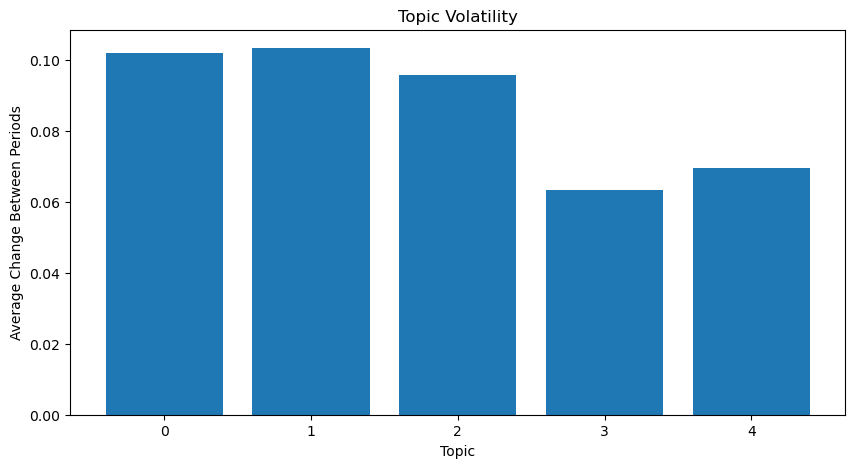

In [73]:
def calculate_topic_volatility(model, time_slices):
    """Calculate how much topics change between periods"""
    volatility = []
    for topic in range(model.num_topics):
        changes = []
        for t in range(1, len(time_slices)):
            prev_terms = dict(model.print_topics(time=t-1)[topic])
            curr_terms = dict(model.print_topics(time=t)[topic])
            
            # Calculate Jaccard similarity of top words
            prev_words = set(dict(sorted(prev_terms.items(), key=lambda x: x[1], reverse=True)[:10]).keys())
            curr_words = set(dict(sorted(curr_terms.items(), key=lambda x: x[1], reverse=True)[:10]).keys())
            
            similarity = len(prev_words & curr_words) / len(prev_words | curr_words)
            changes.append(1 - similarity)
            
        volatility.append(np.mean(changes))
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(model.num_topics), volatility)
    plt.title('Topic Volatility')
    plt.xlabel('Topic')
    plt.ylabel('Average Change Between Periods')
    plt.show()
    
calculate_topic_volatility(dtm, time_slices)

In [74]:
import plotly.graph_objects as go
def plot_topic_strength(model, time_slices):
    """Plot overall topic strength over time"""
    topic_strengths = []
    for t in range(len(time_slices)):
        strengths = []
        for topic in range(model.num_topics):
            # Calculate average word weight
            top_terms = model.print_topics(time=t)[topic]
            avg_weight = np.mean([weight for _, weight in top_terms])
            strengths.append(avg_weight)
        topic_strengths.append(strengths)
    
    fig = go.Figure()
    for topic in range(model.num_topics):
        fig.add_trace(go.Scatter(
            x=list(range(len(time_slices))),
            y=[strengths[topic] for strengths in topic_strengths],
            name=f'Topic {topic}',
            mode='lines+markers'
        ))
    
    fig.update_layout(
        title='Topic Strength Evolution',
        xaxis_title='Time Period',
        yaxis_title='Average Topic Strength'
    )
    return fig
plot_topic_strength(dtm, time_slices).show()

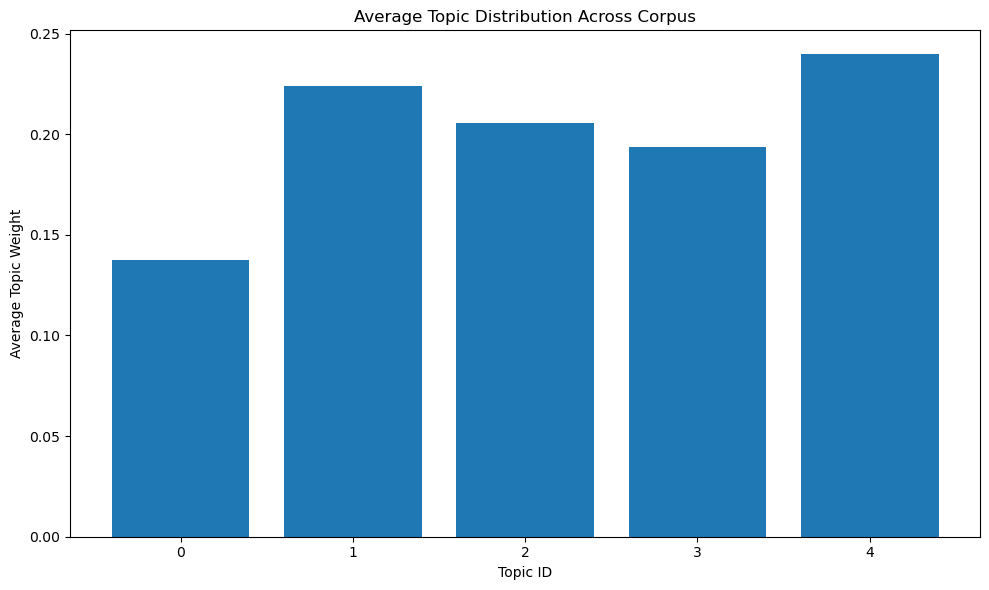

In [90]:
def plot_average_topic_distribution(
    ldaseq: LdaSeqModel,
    doc_ids: list,
    figsize: tuple = (10, 6),
    title = None
) -> None:
    """
    Plot average weight of each topic across all documents.
    
    Args:
        ldaseq: Trained LdaSeqModel
        doc_ids: List of document IDs
        figsize: Figure size as (width, height)
        title: Custom plot title
    """
    # Get topic distributions
    topic_dists = np.array([ldaseq.doc_topics(doc_id) for doc_id in doc_ids])
    
    # Calculate mean and std for each topic
    topic_means = np.mean(topic_dists, axis=0)
    # Create plot
    plt.figure(figsize=figsize)
    topics = range(ldaseq.num_topics)
    
    plt.bar(topics, topic_means, capsize=5)
    plt.xlabel('Topic ID')
    plt.ylabel('Average Topic Weight')
    plt.title(title or 'Average Topic Distribution Across Corpus')
    plt.xticks(topics)
    plt.tight_layout()
    plt.show()

plot_average_topic_distribution(dtm, range(len(corpus)), title='Average Topic Distribution Across Corpus')